In [1]:
import numpy as np
import os
import subprocess
import sys
import json
import matplotlib.pyplot as plt
import torch
import json
import os

In [2]:
colab = False
token = ""
repo_owner = "esemsc-dda24"
repo_name = "PTL-PINNS"

## Using colab?

In [3]:
if colab:

    def clone_repo(repo_owner: str, repo_name: str, token: str = None):
        """
        Clone a GitHub repo using a token. Token can be passed or taken from GITHUB_TOKEN env var.
        """
        token = token or os.getenv("GITHUB_TOKEN")
        if not token:
            raise ValueError("GitHub token not provided or found in environment variables.")

        url = f"https://{token}@github.com/{repo_owner}/{repo_name}.git"
        target_dir = repo_name

        if not os.path.exists(target_dir):
            try:
                subprocess.run(["git", "clone", url], check=True)
                print(f"Successfully cloned '{repo_name}'.")
            except subprocess.CalledProcessError as e:
                print(f"Error cloning repo: {e}")
        else:
            print(f"Directory '{target_dir}' already exists; skipping git clone.")

    clone_repo(repo_owner, repo_name, token)
    sys.path
    sys.path.append(f"/content/{repo_name}/")
    !pip install neurodiffeq > /dev/null 2>&1
    %cd /{repo_name}
    !ls
    !pip install -e .

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from matplotlib import pyplot as plt
from ptlpinns.models import model, train_PDE
from ptlpinns.odes import forcing, equations, numerical

## Training equations

In [5]:
L, T = 2, 5
x_span = (0, L)
t_span = (0, T)
Nx, Nt = 150, 150

In [6]:
def forcing_zeros(input):
    x = input[:, 0].unsqueeze(1)
    return torch.zeros_like(x)

def ic_sin(input):
    x = input[:, 0].unsqueeze(1)
    return torch.sin(torch.pi*x / L)

def ic_zero(input):
    x = input[:, 0].unsqueeze(1)
    return torch.zeros_like(x)

def first_order(D):

    def helper_first_order(input):
        x = input[:, 0].unsqueeze(1)
        t = input[:, 1].unsqueeze(1)

        u_0 = torch.exp(torch.tensor(- D * t * (torch.pi / L) ** 2)) * torch.sin(torch.pi * x / L)
        return u_0 * (1 - u_0)

    return helper_first_order

def general_forcing(n, alpha, D):

    def helper_general_forcing(input):
        x = input[:, 0].unsqueeze(1)
        t = input[:, 1].unsqueeze(1)

        lambda_param = D * (n * torch.pi / L) ** 2

        return torch.exp(- alpha * lambda_param * t) * torch.sin(n * torch.pi * x / L)

    return helper_general_forcing

In [7]:
k = 9
D_list = torch.tensor([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
epsilon_list = torch.tensor([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.5, 0.5, 0.5])

boundary_values = [[0,0]] * k

Forcing_functions = [forcing_zeros, forcing_zeros, forcing_zeros,
                     forcing_zeros, forcing_zeros, forcing_zeros,
                     first_order(D_list[3]), first_order(D_list[4]), first_order(D_list[5])]

initial_conditions = [ic_sin, ic_sin, ic_sin, ic_zero, ic_zero, ic_zero, ic_zero, ic_zero, ic_zero]

In [8]:
PTL_PINN = model.Multihead_model_PDE(k=k, bias=True)

In [ ]:
learning_rate = 1e-3
num_iter= 15000
interior_grid = (15, 15)
Nic = Nx
Nbc = Nt
method='equally-spaced-noisy'
pde_weight = 1; bc_weight = 10; ic_weight=10
every= 400
optimizer=torch.optim.Adam(PTL_PINN.parameters(), lr=learning_rate)
step_size = 750
gamma = 0.95
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [10]:
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
PTL_PINN.to(dev)

loss_trace, pde_trace, ic_trace, bc_trace, result_trace = train_PDE.train(model=PTL_PINN, optimizer=optimizer, num_iter=num_iter, Forcing_functions=Forcing_functions,
                                                                        boundary_values=boundary_values, initial_value=initial_conditions, coeff=D_list,
                                                                        interior_grid=interior_grid, x_span=x_span, t_span=t_span,
                                                                        Nic=Nic, Nbc=Nbc, every=100, pde_weight=pde_weight, bc_weight=bc_weight,
                                                                        ic_weight=ic_weight, scheduler=scheduler, method=method, equation = "KPP-Fisher_nonlinear", epsilon=epsilon_list)

  0%|          | 0/30000 [00:00<?, ?it/s]

/home/dda24/downloads/miniconda3/envs/mpm2024/lib/python3.12/site-packages/torch/utils/_device.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


[   100] Iter | Total: 7.0391e-02 | PDE: 2.1800e-02 (w=1) | IC: 2.6367e-03 (w=10) | BC: 2.2223e-03 (w=10)
[   200] Iter | Total: 1.5055e-02 | PDE: 1.2742e-02 (w=1) | IC: 1.6031e-04 (w=10) | BC: 7.0935e-05 (w=10)
[   300] Iter | Total: 1.2770e-02 | PDE: 1.1963e-02 (w=1) | IC: 4.8955e-05 (w=10) | BC: 3.1678e-05 (w=10)
[   400] Iter | Total: 2.0697e-02 | PDE: 1.2009e-02 (w=1) | IC: 1.1589e-04 (w=10) | BC: 7.5284e-04 (w=10)
[   500] Iter | Total: 1.1954e-02 | PDE: 1.1504e-02 (w=1) | IC: 2.3161e-05 (w=10) | BC: 2.1857e-05 (w=10)
[   600] Iter | Total: 2.1497e-02 | PDE: 1.1593e-02 (w=1) | IC: 1.4761e-04 (w=10) | BC: 8.4274e-04 (w=10)
[   700] Iter | Total: 1.1412e-02 | PDE: 1.0975e-02 (w=1) | IC: 2.2532e-05 (w=10) | BC: 2.1192e-05 (w=10)
[   800] Iter | Total: 1.1199e-02 | PDE: 1.0795e-02 (w=1) | IC: 1.8939e-05 (w=10) | BC: 2.1492e-05 (w=10)
[   900] Iter | Total: 1.1195e-02 | PDE: 1.0670e-02 (w=1) | IC: 2.2597e-05 (w=10) | BC: 2.9890e-05 (w=10)
[  1000] Iter | Total: 1.1179e-02 | PDE: 1.071

KeyboardInterrupt: 

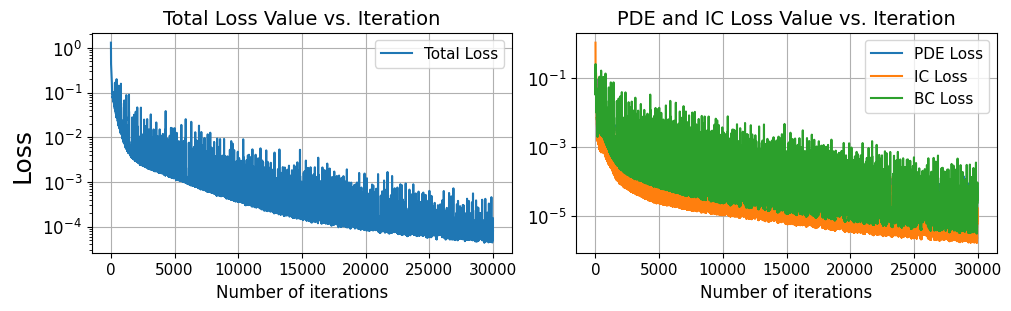

In [ ]:
train_PDE.plot_loss(loss_trace, pde_trace, bc_trace, ic_trace)

In [ ]:
# compute the NN solutions
PTL_PINN.eval()
x, tau, grid = train_PDE.generate_interior_tensor(IG=(Nx, Nt), x_span=(0, L), t_span=(0, T), require_grad=False)
NN_solution, _ = PTL_PINN(grid.to(dev))

NN_solution = NN_solution.mT.reshape((k,Nx, Nt)).detach().cpu().numpy()

In [ ]:
NN_solution.shape

(9, 150, 150)

In [ ]:
x = np.linspace(x_span[0], x_span[1], Nx)
t = np.linspace(t_span[0], t_span[1], Nt)
mesh_x, mesh_t = np.meshgrid(x, t)

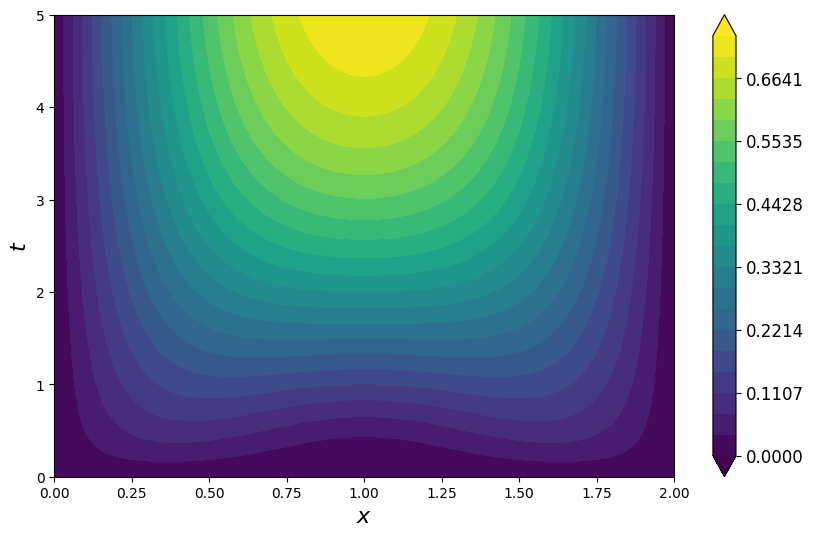

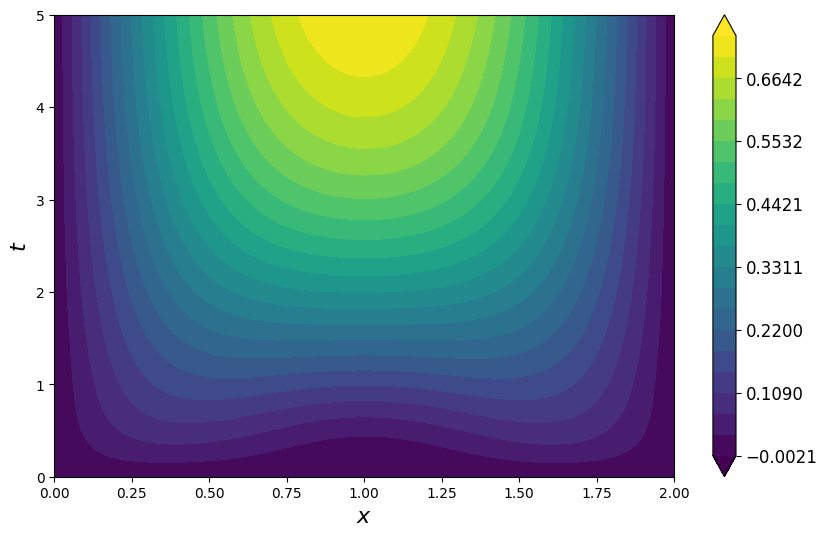

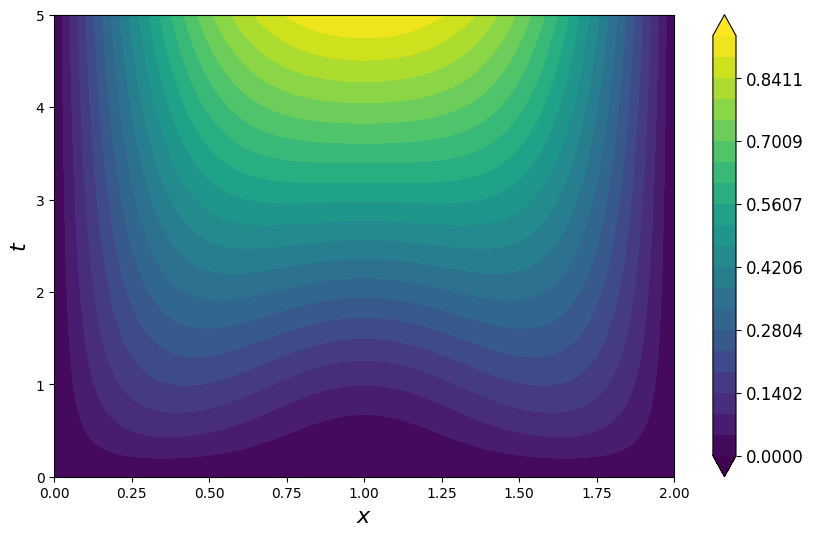

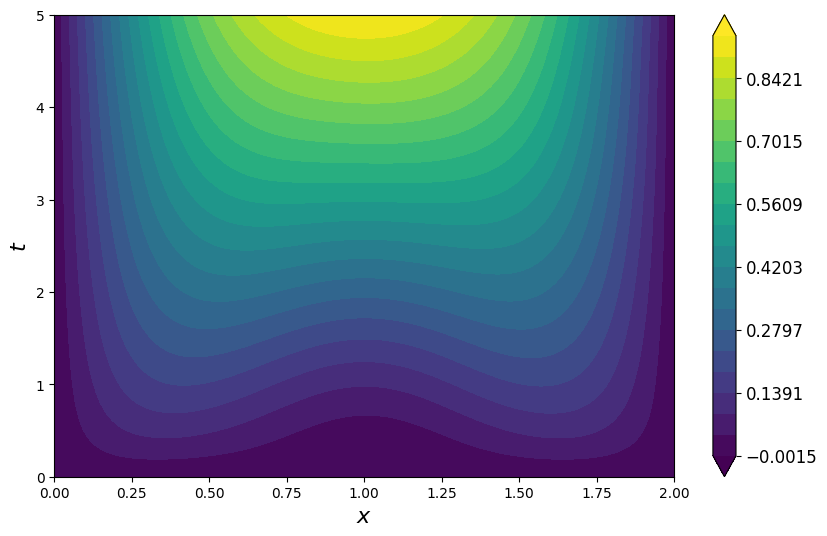

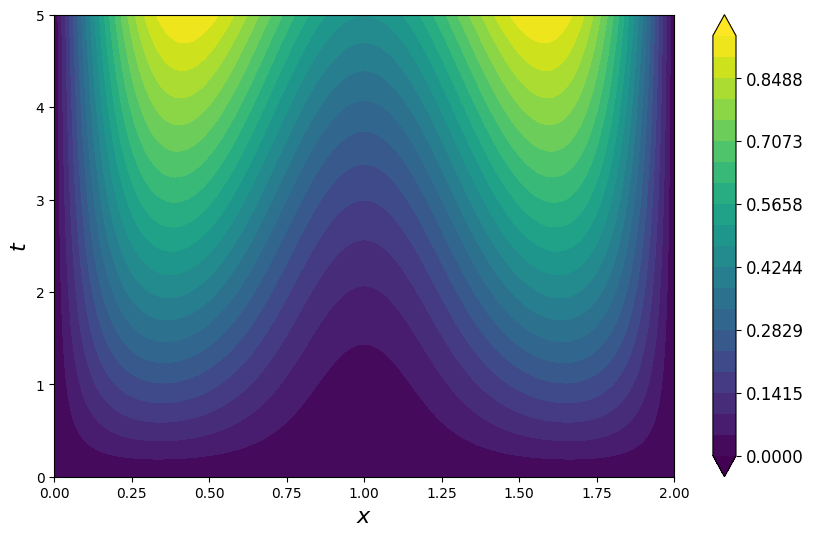

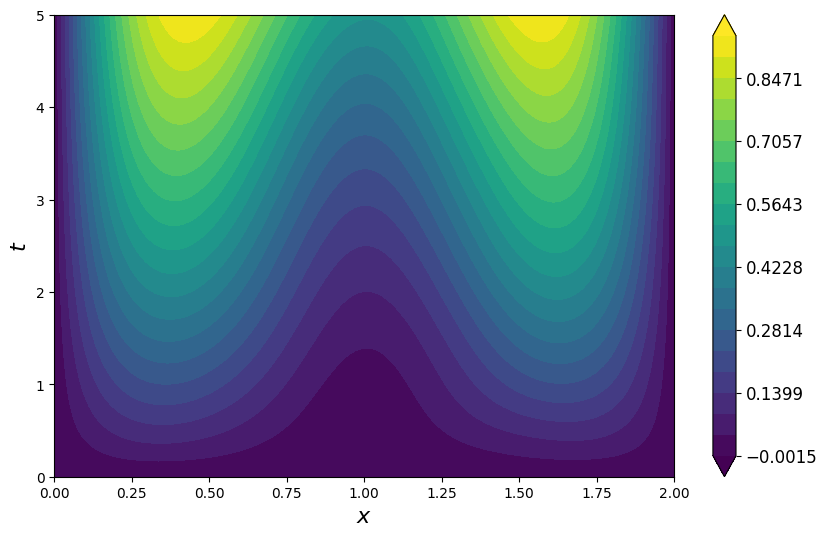

In [ ]:
def zero_initial(x):    
  return np.zeros_like(x)

numerical_solutions = []

D_list = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
epsilon_list = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.5, 0.5, 0.5])

for i in range(len(epsilon_list)):

  u_0 = [zero_initial]
  forcing = [lambda x, t: numerical.kpp_fisher_u0(x, t, L, D_list[i]) * (1 - numerical.kpp_fisher_u0(x, t, L, D_list[i]))]
  bcs = [[lambda t: 0, lambda t: 0]]
  polynomial = [lambda u: -u + u**2 for _ in range(len(epsilon_list))]
  result_kpp = numerical.solution_KPP(epsilon_list[i], D_list[i], polynomial, x_span, t_span, Nx, Nt, u_0, forcing, bcs).squeeze().swapaxes(0, 1)
  numerical_solutions.append(result_kpp)

  numerical.plot_solution_PDE(result_kpp, mesh_x, mesh_t, surface=False)
  numerical.plot_solution_PDE(NN_solution[i].swapaxes(0, 1), mesh_x, mesh_t, surface=False)

0


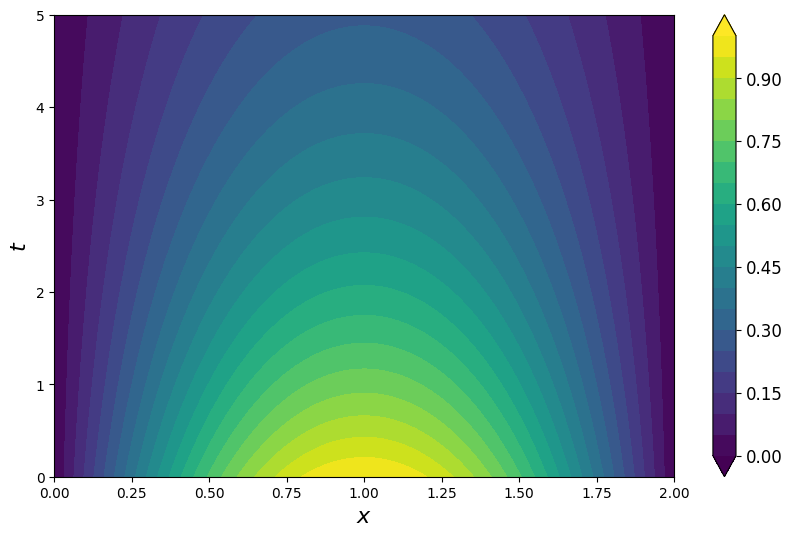

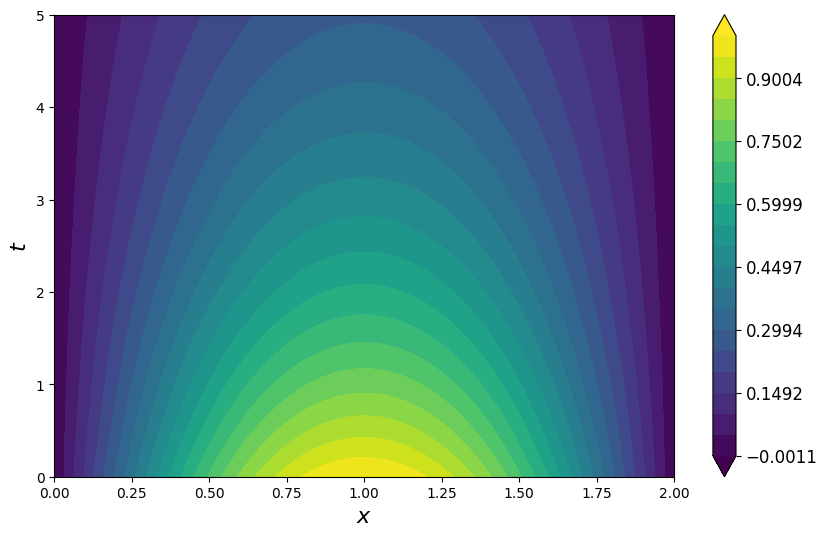

1


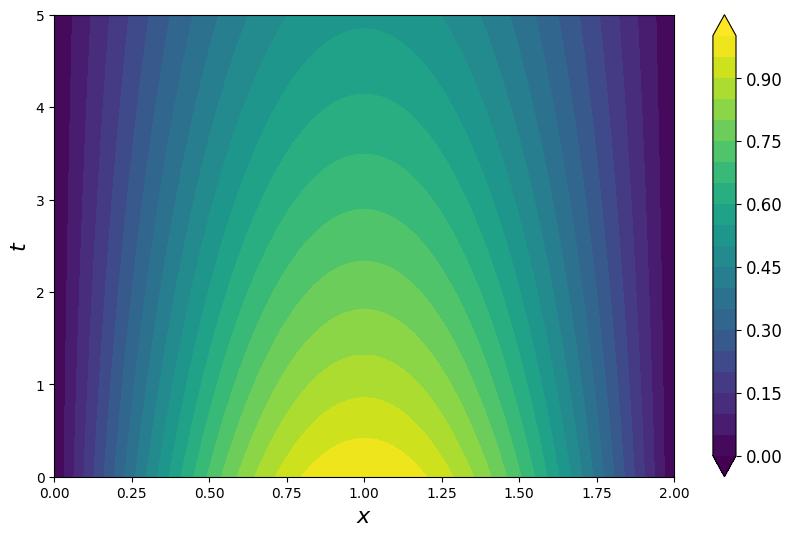

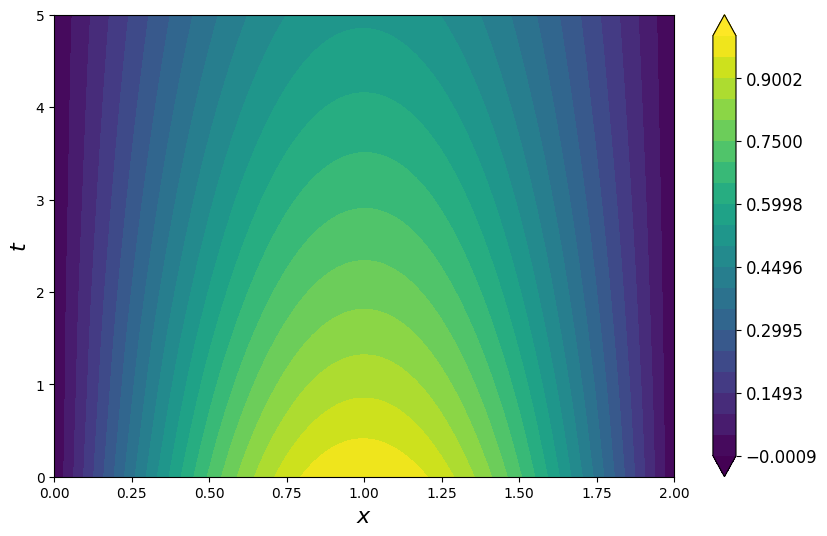

2


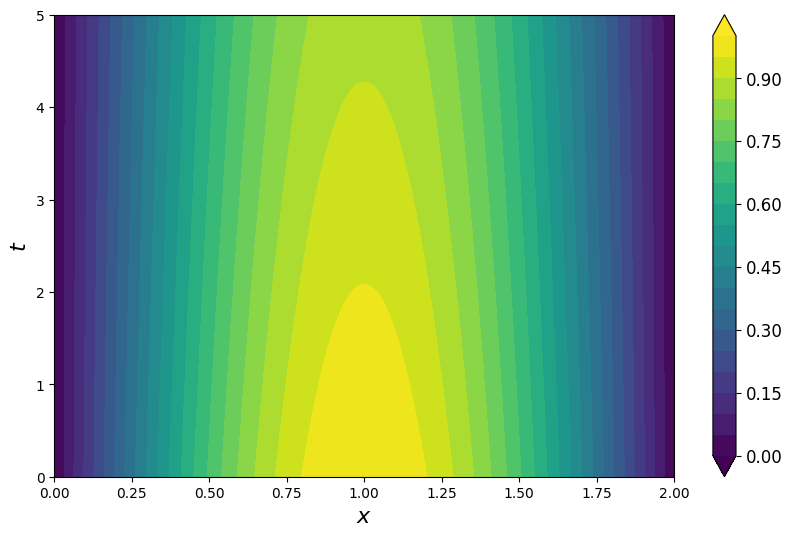

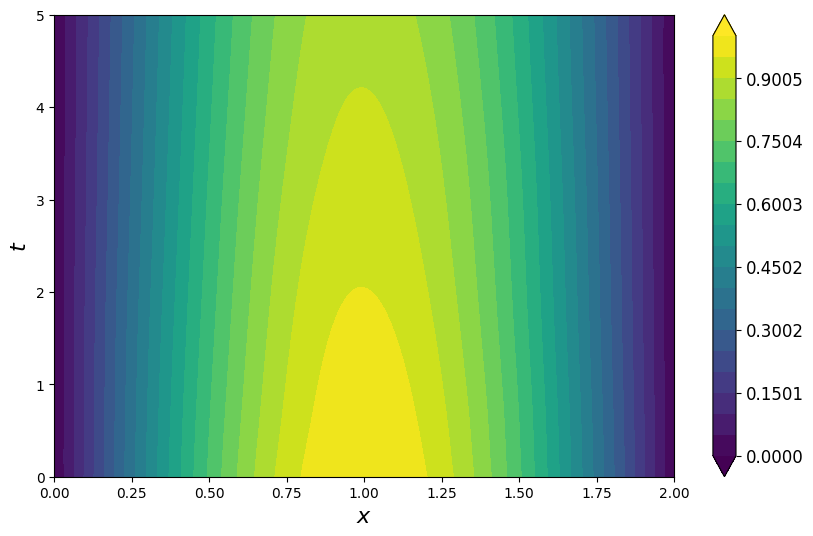

3


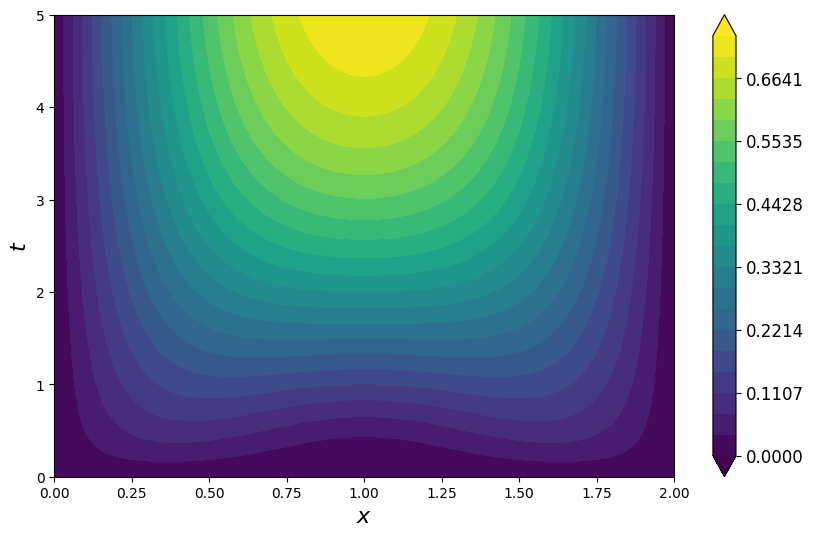

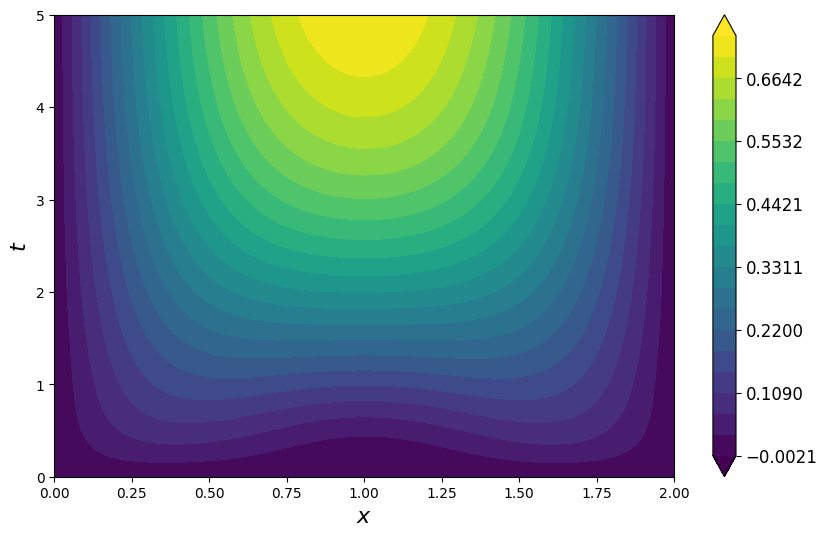

4


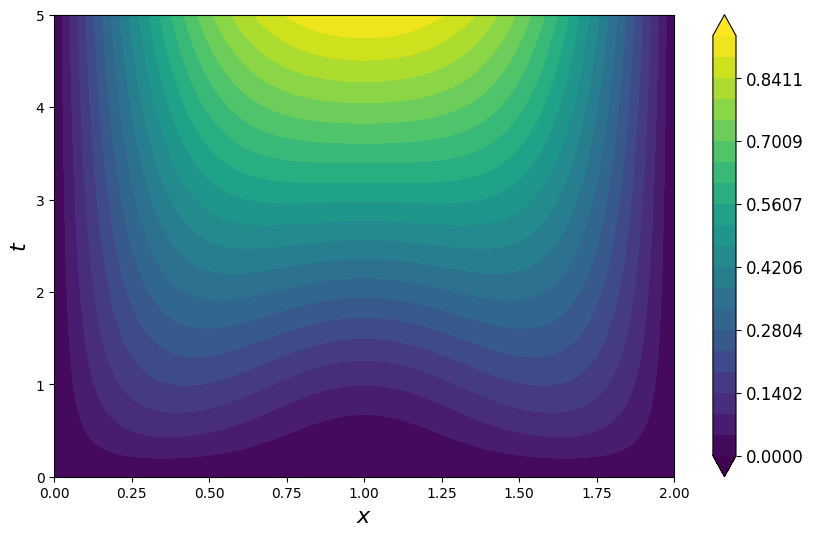

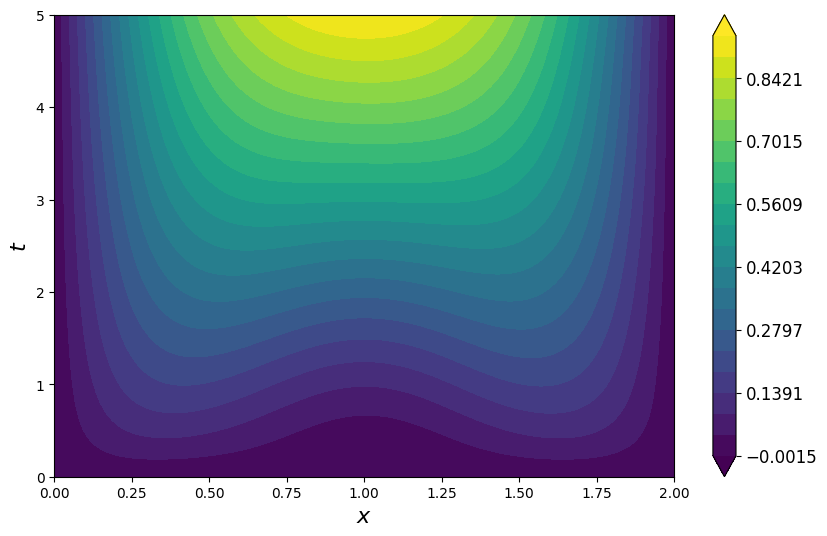

5


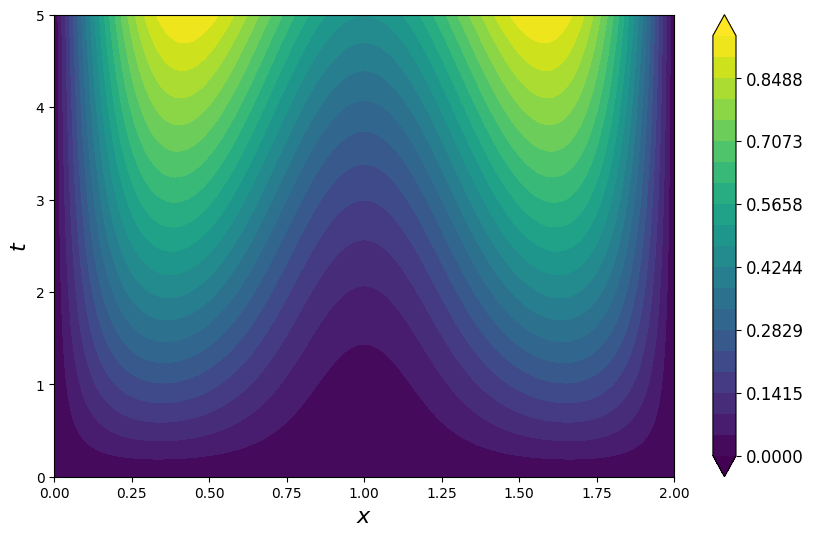

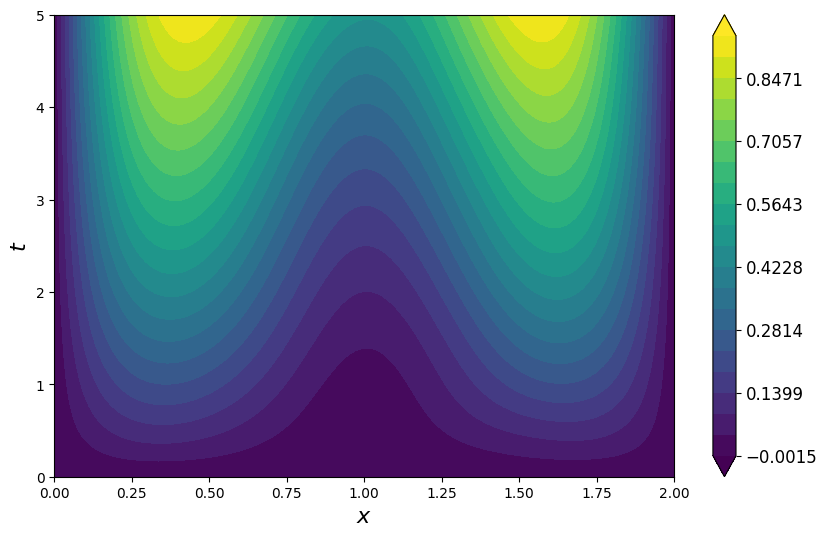

In [ ]:
for j in range(len(epsilon_list)):
  numerical.plot_solution_PDE(numerical_solutions[j], mesh_x, mesh_t, surface=False)
  numerical.plot_solution_PDE(NN_solution[j].swapaxes(0, 1), mesh_x, mesh_t, surface=False)

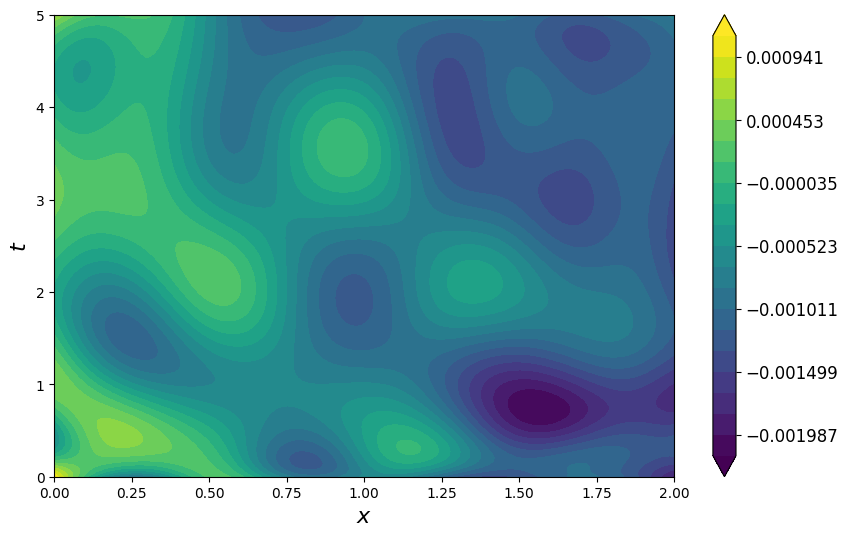

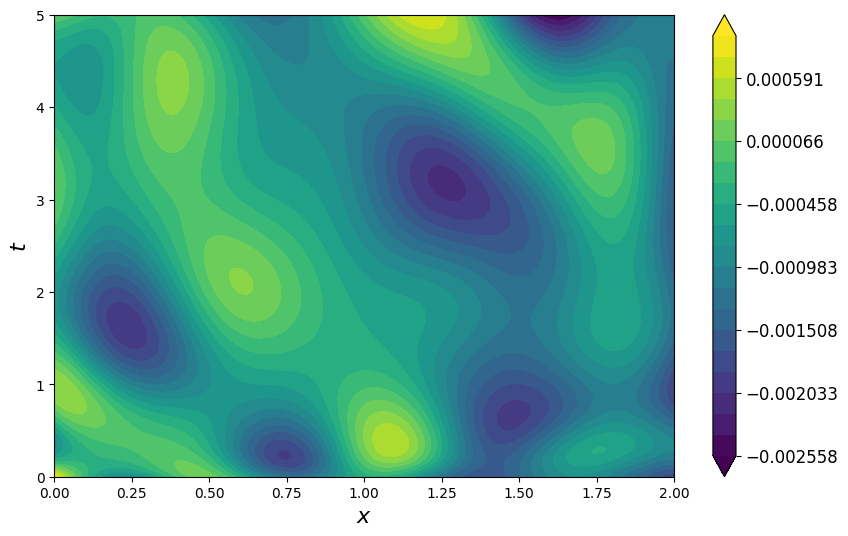

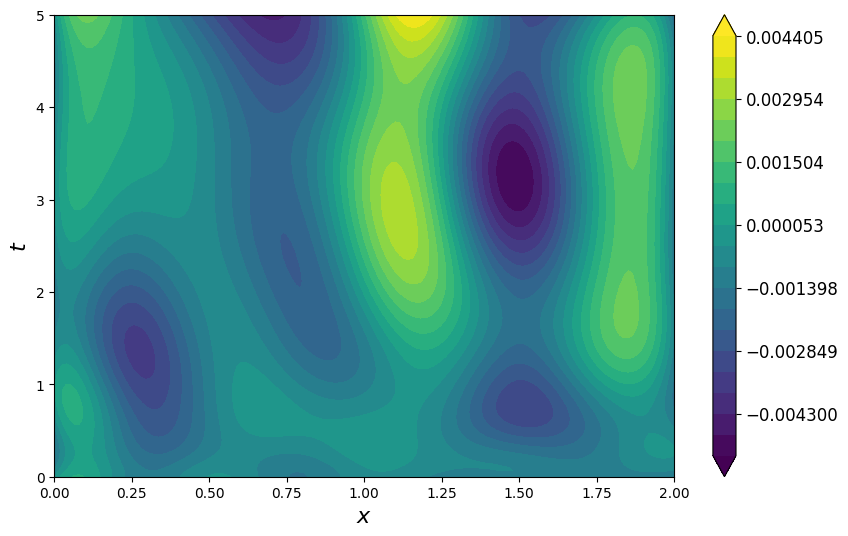

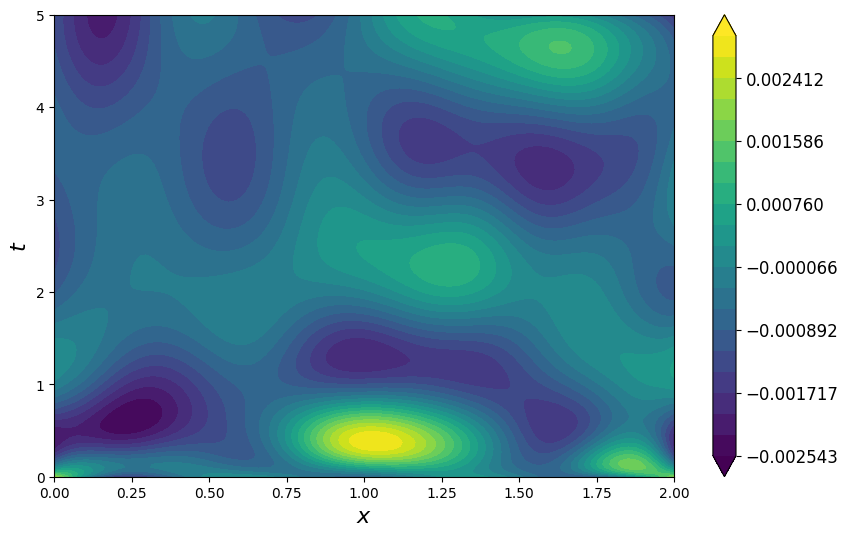

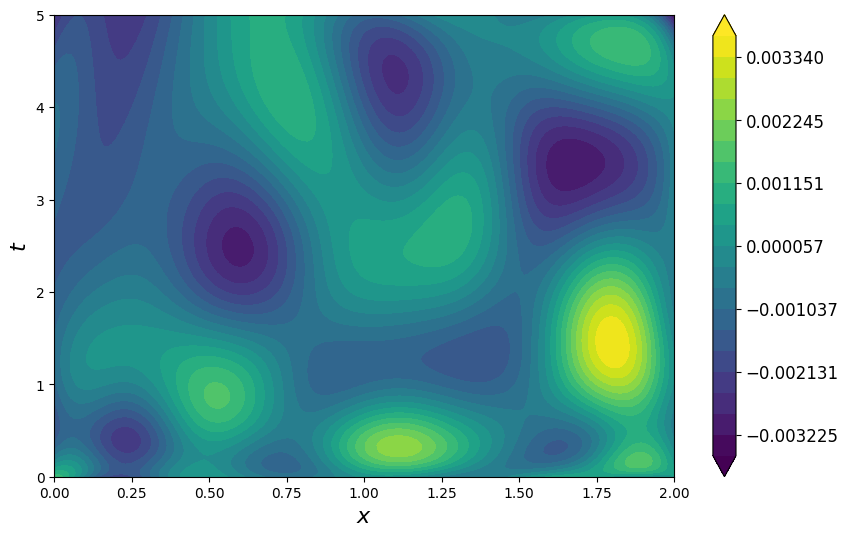

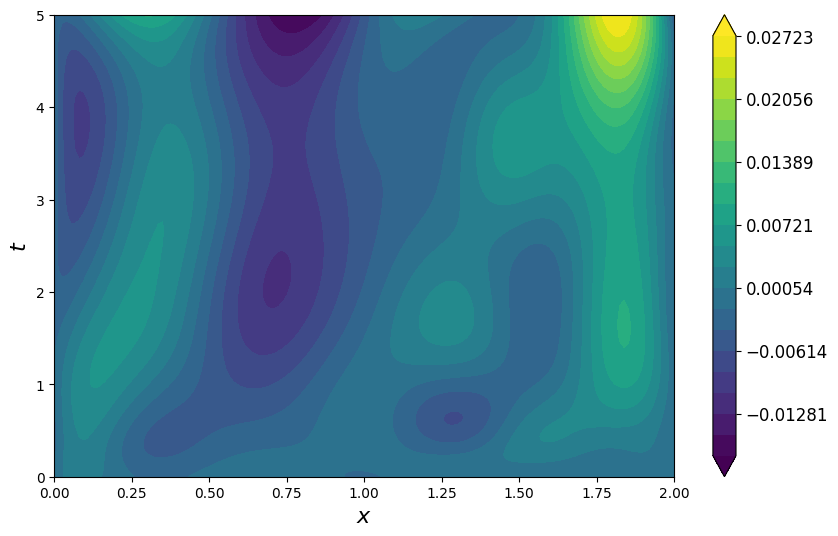

In [ ]:
for i in range(len(epsilon_list)):
    numerical.plot_solution_PDE(numerical_solutions[i] - NN_solution[i].swapaxes(0, 1), mesh_x, mesh_t, surface=False)

In [ ]:
name = "KPP_Fisher_nonlinear"
PTL_PINN.to('cpu')
torch.save(PTL_PINN.state_dict(), f"/content/PTL-PINNS/model_{name}.pth")